### NMS - Double Thresholding & Tracking by hysteresis

1. Low threshold (0.5) 이하의 값을 가지면 sketch가 아니다.
2. High threshold (0.8) 이상의 값을 갖고 spatial similarity 와 선명도가 크고 Level of misalignment (DT로 계산) 가 가장 작은 픽셀은 강 sketch이다.
    - Similarity가 높고 GT에 가장 가까운 sketch를 선택
    - strong sketch
3. 그 가운데 (0.5 ~ 0.7) 의 값을 갖는 곳은 아래 후처리를 거침.
    - 만약 flowpath 상에 strong sketch가 많다면 weak sketch로 인정
    - 주변에 strong sketch가 전혀 없다면, 원본 GT를 그대로 weak sketch로 사용
4. Closing 연산으로 한 칸씩 끊어진 sketch들을 이어줌.

### 입력과 출력
- 입력: Prediction sketch & target sketch의 distance map의 합
- 출력: enhanced target sketch

# Hyper parameters

In [1]:
import os

BASE_PATH = os.path.join("Misaligned_sketches_sample_data", "Hard", "hard_4", "inputs")

# 입력
FLOWPATH_PATH = os.path.join(BASE_PATH, "hard_4_flowpath.npz")
TARGET_PATH = os.path.join(BASE_PATH, "hard_4_target.png")
INFODRAW_PATH = os.path.join(BASE_PATH, "hard_4_infodraw.png")
VTF_PATH = os.path.join(BASE_PATH, "hard_4_vtf.npz")


# prediction에 관련한 threshold
PRED_HIGH_CONF_THRESHOLD = 0.7
PRED_LOW_CONF_THRESHOLD = 0.5

# NMS step2에서 사용하는 threshold
DISTMAP_ALPHA = 10
COMBINED_DIST_HIGH_THRESHOLD = 0.8
COMBINED_DIST_LOW_THRESHOLD = 0.5
SPATIAL_SIM_THRESHOLD = 0.5

# weak sketch params
N_CLOSING_FP = 7 # (N_CLOSING_FP + 1 + N_CLOSING_FP)
WEAK_SKETCH_CONVERSION_COUNT = N_CLOSING_FP + 1
WEAK_SKETCH_CONVERSION_THRESHOLD = 0.5

# Prerequisite
### 1. predict sketch from VTF of noisy sketch (infodraw)
### 2. Bledn prediction and distance map of target sketch

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init

import numpy as np
import cv2
import matplotlib.pyplot as plt

from src.dataloaders import FPathDataset, FPathLazyDataset
from src.preprocesses import VTFPreprocessor, InfodrawPreprocessor, TargetPreprocessor, ImagePreprocessor
from train2 import FCModel, CNNModel, ResCNN1DLayer, FPathDataset

In [3]:
# 1.0. Definition of model

# class FCModel(nn.Module):
#     def __init__(self, in_channel=21, out_channel=1):
#         super().__init__()
#         self.in_channel = in_channel
#         self.out_channel = out_channel
#         self.layer1 = nn.Sequential(
#             ResFCLayer(in_channel, 128, bias=True),
#             ResFCLayer(128, 128, bias=True),
#             ResFCLayer(128, 128, bias=True)
#         )
#         self.final_layer = nn.Sequential(
#             ResFCLayer(128, 128, bias=True, dropout_p=0.5),
#             nn.Linear(128, 1, bias=True)
#         )
        
#     def forward(self, fpath_list_tensor):
#         out = self.layer1(fpath_list_tensor)
#         out = self.final_layer(out)
#         return torch.sigmoid(out)

In [4]:
# 1. predict sketch from VTF of noisy sketch (infodraw)

# 1.1. Load model
model = torch.load(os.path.join("weights", "best_CNNModel_acc78.31.pth")) # FCModel

model = model.to('cpu')
model = model.eval()

In [5]:
# 1.2. load vtf and predict
from tqdm import tqdm
from src.preprocesses import VTFPreprocessor, InfodrawPreprocessor

vtf = VTFPreprocessor.get(VTF_PATH)
infodraw = InfodrawPreprocessor.get(INFODRAW_PATH)

print(f"vtf: {np.mean(vtf, axis=0).shape}")
plt.imsave("0_vtf_visualize.png", np.mean(vtf, axis=0), vmin=0, vmax=1)



vtf_tensor = torch.tensor(vtf).unsqueeze(0).to("cpu")
infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to("cpu")
_, _, H, W = infodraw_tensor.shape

print(f"H, W: {H, W}")

prediction = np.zeros((H, W))
for h in tqdm(range(H)):
    for w in range(W):
        if infodraw_tensor[0, 0, h, w] < 0.99:
            selected_vtf = vtf_tensor[0, :, h, w]
            
            pred = model(selected_vtf.unsqueeze(0))
            # pred = 1.0 if pred > 0.5 else 0.0
            
            # 현재는 확률이 0에 가까울 수록 sketch,
            # 1에 가까울 수록 배경이다.
            # sketch를 1로 보자고 했으니 이를 역전 시킴.
            prediction[h, w] = 1 - pred.item()

/tmp/ipykernel_2757390/2920637305.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  infodraw_tensor = torch.tensor(infodraw).unsqueeze(0).to("cpu")


vtf: (1024, 728)
H, W: (1024, 728)


100%|██████████| 1024/1024 [01:33<00:00, 10.98it/s] 


In [6]:
# prediction 그 자체 출력
plt.imsave("1_prediction.png", prediction, vmin=0, vmax=1)

# HIGH THRESHOLD 이상의 값을 갖는 prediction만 남김.
high_conf_mask = prediction >= PRED_HIGH_CONF_THRESHOLD
high_conf_prediction = prediction * high_conf_mask
# high conf prediction 중간 결과 출력
plt.imsave("1_1_prediction_high_conf.png", high_conf_prediction, vmin=0, vmax=1)

# LOW THRESHOLD 미만의 값을 갖는 prediction만 출력
low_conf_mask = prediction < PRED_LOW_CONF_THRESHOLD 
low_conf_prediction = prediction * low_conf_mask
plt.imsave("1_2_prediction_low_conf.png", low_conf_prediction, vmin=0, vmax=1)

# HIGH_CONF도 아니고 LOW CONF도 아닌 그 가운데 픽셀들
middle_conf_mask = (1 - high_conf_mask) * (1 - low_conf_mask)
middle_conf_prediction = prediction * middle_conf_mask
plt.imsave("1_3_prediction_middle_conf.png", middle_conf_prediction, vmin=0, vmax=1)

In [7]:
import math

# 2. Bledn prediction and distance map of target sketch
# 2.1. Get distance map from target sketch

# jump flooding algorithm for calculate distance map from target sketch

class SeedInfo:
    def __init__(self):
        self.sid = -1
        self.dist = float('inf')
        self.dist_arc = 1.0
        self.clr = np.zeros(3)
        self.sx, self.sy = 0, 0
        self.isseed = False

    def set(self, sid_, d, clr_, sx_, sy_):
        self.sid = sid_
        self.dist = d
        self.clr = clr_.copy()
        self.sx = sx_
        self.sy = sy_

    def update(self, new_sid, new_dist):
        if new_dist < self.dist:
            self.dist = new_dist
            self.sid = new_sid
            
class JFA:
    def __init__(self, max_x, max_y):
        self.MAX_X = max_x
        self.MAX_Y = max_y
        self.dmap = np.array([[SeedInfo() for _ in range(self.MAX_Y)] for _ in range(self.MAX_X)])
        self.outClr = np.zeros((self.MAX_X, self.MAX_Y, 3))

    def init_jfa(self):
        self.dmap = np.array([[SeedInfo() for _ in range(self.MAX_Y)] for _ in range(self.MAX_X)])
        self.outClr = np.zeros((self.MAX_X, self.MAX_Y, 3))

    def is_zero_vector(self, v):
        return np.all(v == 0)

    def jump_flooding(self, InSeeds):
        print(f"Start jump flooding algorithm..")
        seeds = []
        cnt = 0

        # Step 1: Seed initialization
        print(f"\tStep 1: Seed initialization")
        for i in tqdm(range(self.MAX_X)):
            for j in range(self.MAX_Y):
                if not self.is_zero_vector(InSeeds[i][j]):
                    seeds.append((i, j))
                    self.dmap[i][j].set(cnt, 0.0, InSeeds[i][j], i, j)
                    self.dmap[i][j].isseed = True
                    cnt += 1

        nseeds = cnt
        k = min(self.MAX_X, self.MAX_Y)

        # Step 2: Jump flooding algorithm
        print(f"\tStep 2: Jump flooding algorithm")
        while k >= 1:
            new_seeds = []
            for px, py in seeds:
                for r in range(px - k, px + k + 1, k):
                    for c in range(py - k, py + k + 1, k):
                        if (r == px and c == py) or not (0 <= r < self.MAX_X and 0 <= c < self.MAX_Y):
                            continue

                        idx = self.dmap[px][py].sid
                        sx, sy = seeds[idx]
                        d = math.sqrt((r - sx)**2 + (c - sy)**2)

                        if self.dmap[r][c].dist > d:
                            self.dmap[r][c].set(self.dmap[px][py].sid, d, self.dmap[sx][sy].clr, sx, sy)
                            if not self.dmap[r][c].isseed:
                                self.dmap[r][c].isseed = True
                                new_seeds.append((r, c))

            seeds.extend(new_seeds)
            nseeds = len(seeds)
            k //= 2

        # Step 3: Copy color information
        print(f"\tStep 3: Copy color information")
        for i in range(self.MAX_X):
            for j in range(self.MAX_Y):
                self.outClr[i][j] = self.dmap[i][j].clr

        # Step 4: Find maximum distance
        print(f"\tStep 4: Find maximum distance")
        maxdist = 0.0
        threshold = float('inf')
        for i in range(self.MAX_X):
            for j in range(self.MAX_Y):
                if self.dmap[i][j].dist <= threshold:
                    maxdist = max(maxdist, self.dmap[i][j].dist)

        # Step 5: Normalize distances
        print(f"\tStep 5: Normalize distances")
        for i in range(self.MAX_X):
            for j in range(self.MAX_Y):
                if self.dmap[i][j].dist > threshold:
                    self.dmap[i][j].dist_arc = 1.0
                else:
                    self.dmap[i][j].dist_arc = self.dmap[i][j].dist / maxdist

    def draw_distmap(self, show=False):
        print(f"Drawing distance map")
        dist_map = np.zeros((self.MAX_X, self.MAX_Y), dtype=np.float32)
        for i in range(self.MAX_X):
            for j in range(self.MAX_Y):
                dist_map[i][j] = self.dmap[i][j].dist_arc
        if show:
            plt.imshow(dist_map, cmap='gray')
            plt.show()
        
        return dist_map

    def draw_voronoi(self, show=False):
        print(f"Drawing Voronoi map")
        voronoi_map = np.zeros((self.MAX_X, self.MAX_Y, 3))
        for i in range(self.MAX_X):
            for j in range(self.MAX_Y):
                voronoi_map[i][j] = self.dmap[i][j].clr
        if show:
            plt.imshow(voronoi_map)
            plt.show()
        
        return voronoi_map

In [8]:
# 2.1. calculate distance map from target sketch

seed_img = cv2.imread(TARGET_PATH)
seed_img = cv2.cvtColor(seed_img, cv2.COLOR_BGR2RGB)
seed_img = np.float32(seed_img)
seed_img = 1 - (seed_img / 255.0)

MAX_Y, MAX_X, CHANNEL = seed_img.shape
print(f"MAX_X, MAX_Y: {MAX_X, MAX_Y}")

jfa_instance = JFA(MAX_Y, MAX_X)

jfa_instance.jump_flooding(seed_img)
distmap = jfa_instance.draw_distmap()

MAX_X, MAX_Y: (728, 1024)
Start jump flooding algorithm..
	Step 1: Seed initialization


100%|██████████| 1024/1024 [00:02<00:00, 381.18it/s]


	Step 2: Jump flooding algorithm
	Step 3: Copy color information
	Step 4: Find maximum distance
	Step 5: Normalize distances
Drawing distance map


In [9]:
# cv2.imwrite("2distmap.png", np.uint8(np.stack([255*(1-distmap), 255*np.ones_like(result), 255*np.ones_like(result)], axis=2)))
plt.imsave("2_distmap.png", distmap, vmin=0, vmax=1)


distmap_inv_alpha = (1 - distmap)**DISTMAP_ALPHA
# cv2.imwrite("3distmap_inv_alpha50.png", np.uint8(np.stack([255*(distmap_inv_alpha), 255*np.zeros_like(result), 255*np.zeros_like(result)], axis=2)))
plt.imsave("2_1_distmap_inv_alpha50.png", distmap_inv_alpha, vmin=0, vmax=1)

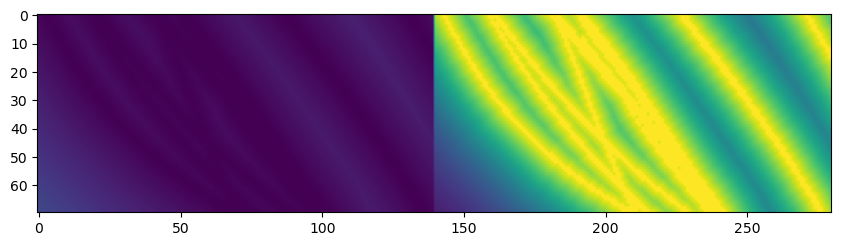

In [10]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(np.concatenate([distmap[250:320, 480:620], distmap_inv_alpha[250:320, 480:620]], axis=1), vmin=0, vmax=1)

# Blend prediction and distance map

In [11]:
pred_add_dist_inv_alpha = cv2.addWeighted(np.array(prediction, dtype=np.float32), 0.5, distmap_inv_alpha, 0.5, 0)

plt.imsave("2_2_pred_add_dist_inv_alpha.png", pred_add_dist_inv_alpha, vmin=0, vmax=1)

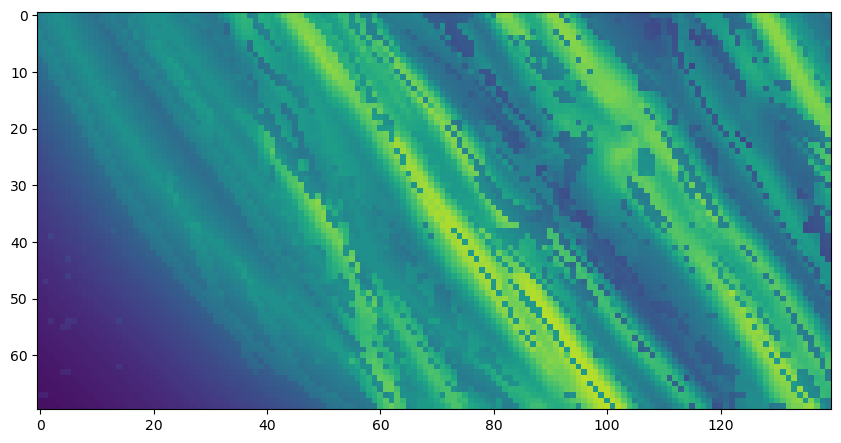

In [12]:
plt.figure(figsize=(10.24, 10.24))
plt.imshow(pred_add_dist_inv_alpha[250:320, 480:620], vmin=0, vmax=1)

# NMS - Double Thresholding & Tracking by hysteresis

### 1. Low threshold (0.5) 미만의 값을 가지면 sketch가 아니다.

In [13]:
combine_high_threshold_mask = pred_add_dist_inv_alpha >= COMBINED_DIST_HIGH_THRESHOLD 
nms_step_1 = combine_high_threshold_mask * pred_add_dist_inv_alpha

plt.imsave("3_1_nms_step_1_combine_over_high_conf.png", nms_step_1)

### 2. High threshold (0.8) 이상의 값을 갖고 spatial similarity와 선명도가 크면 sketch이다.

In [14]:
from src.utils import point_interpolate_from_gray_image

# NMS step 2 에서 사용하는 함수 정의

def flowpath_find_center_point(h, w, flowpath):
    # flowpath는 기준 픽셀을 기준으로 normalized tangent를 따라가며
    # 저장된 21개 이하의 픽셀 위치 벡터들임. 
    # 만약 flowpath의 벡터들의 갯수가 21개 미만이라면 남은 부분은 (-1, -1) 로 채워짐.
    # 여기서 중심이 항상 11 (index==10)번째가 아닐 수 있음.
    # 따라서 이를 찾아주는 과정이 필요함.
    
    # 입력: h, w: 는 현재 이미지 상에 위치한 기준 픽셀, flowpath: flowpath
    # 출력: center pos가 없는 경우도 존재. 따라서 찾는데 성공 할 수도 못할 수도 있음.
    
    cur_pos = None
    is_success = False
    for i, (x, y) in enumerate(flowpath):
        if x < 0 or y < 0: continue # (-1, -1) vector는 무시
        # 현재 기준 픽셀 (h, w) 와 flowpath 상에 저장된 픽셀 벡터 간의 거리가 1미만이면
        # 기준 픽셀
        if (y-h)*(y-h) + (x-w)*(x-w) < 1.0:
            cur_pos = i
            is_success = True
            break
        
    return is_success, cur_pos

def calculate_tangetn_from_fp_with_centor_point(cur_pos, fp):
    if 20 > cur_pos > 0:
        x_prev, y_prev = fp[cur_pos-1]
        x_next, y_next = fp[cur_pos+1]
        if (x_prev < 0 or y_prev < 0) and (x_next < 0 or y_next < 0):
            raise RuntimeError(f"Gradient를 구하는데 잘못됨. cur_pos: {cur_pos}, flowpath: {fp}")
        elif x_prev < 0 or y_prev < 0: # cur_pos-1 의 flowpath는 없고 cur_pos+1은 있음.
            tangent = fp[cur_pos+1] - fp[cur_pos]
        elif x_next < 0 or y_next < 0: # cur_pos+1의 flowpath는 없고 curpos-1은 있음.
            tangent = fp[cur_pos] - fp[cur_pos-1]
        else: # 모두 있음.
            tangent = fp[cur_pos+1] - fp[cur_pos-1]
    elif cur_pos == 0:
        # print(f"cur_pos: {cur_pos}, x_next: {x_next}, y_next: {y_next}")
        x_next, y_next = fp[cur_pos+1]
        if x_next < 0 or y_next < 0:
            raise RuntimeError(f"Gradient를 구하는데 잘못됨. cur_pos: {cur_pos}, flowpath: {fp}")
        else:
            tangent = fp[cur_pos+1] - fp[cur_pos]
    else: # cur_pos == 20:
        x_prev, y_prev = fp[cur_pos-1]
        if x_prev < 0 or y_prev < 0:
            raise RuntimeError(f"Gradient를 구하는데 잘못됨. cur_pos: {cur_pos}, flowpath: {fp}")
        else:
            tangent = fp[cur_pos] - fp[cur_pos-1]
    
    return tangent

def calculate_normalized_gradient(tangent):
    tangent_xyz = np.array([tangent[0], tangent[1], 0], dtype=np.float64)
    z_axis = np.array([0, 0, 1], np.float32)
    gradient = np.cross(tangent_xyz, z_axis)
    norm_gradient = gradient / np.linalg.norm(gradient)
    
    return norm_gradient

def gradient_path_from_point(norm_gradient, N=3, do_round=False):
    global SPATIAL_SIM_THRESHOLD
    
    # gradient는 flowpath의 tangent로 계산되어 (x, y) 순서임.
    ngx, ngy = norm_gradient[0], norm_gradient[1] # each x, y values of normalized gradient
    
    if do_round:
        pos_traversing_pixels = np.array([(round(h+n*ngy), round(w+n*ngx)) for n in range(-N, N+1)])
    else:
        pos_traversing_pixels = np.array([(h+n*ngy, w+n*ngx) for n in range(-N, N+1)])
        
    return pos_traversing_pixels

def pick_maxval_through_pixels(pos_traversing_pixels, img):
    # pos_traversing_pixels: gradient path를 기반으로 구한 pixels들의 위치
    # img: pos_traversing_pixels가 따라갈 이미지 (spatial similarity map)

    intensities_through_pixels = []    
    for pos in pos_traversing_pixels:
        y, x = pos
        if x > W-1 or y > H-1:
            continue
        intensity = point_interpolate_from_gray_image(x, y, img)
        intensities_through_pixels.append(intensity)
    
    maxval = max(intensities_through_pixels)
    if maxval < SPATIAL_SIM_THRESHOLD:
        return False, None
    else:
        return True, maxval
    
def find_aligned_sketch(h, w, pos_traversing_pixels, img):
    # h, w: current position
    # pos_traversing_pixels: gradient path를 기반으로 구한 pixels들의 위치
    # img: pos_traversing_pixels가 따라갈 이미지 (spatial similarity map)

    aligned_sketch_positions = []    
    for pos in pos_traversing_pixels:
        y, x = pos
        if x > W-1 or y > H-1:
            continue
        intensity = point_interpolate_from_gray_image(x, y, img)
        
        # 주위 4개의 pixel 중 하나라도 스케치가 있다면
        if intensity > 0.24: # y, x 에 aligned sketch가 존재함.
            # 가장 가까운 pixel 의 위치를 구하기 위해 distance를 계산함.
            distance = (y-h)*(y-h) + (x-w)*(x-w)
            aligned_sketch_positions.append((distance, y, x))
    
    if not aligned_sketch_positions:
        return False, None
    else:
        closest_aligned_sketch_position = None
        mindist = 1e5
        for distance, y, x in aligned_sketch_positions:
            if distance < mindist:
                mindist = distance
                closest_aligned_sketch_position = (y, x)
        
        print(f"closest_aligned_sketch_positions: {aligned_sketch_positions}")
        return True, closest_aligned_sketch_position
    


In [15]:
from src.utils import point_interpolate_from_gray_image

# nms_step_2_mask = pred_add_dist_inv_alpha > COMBINED_DIST_HIGH_THRESHOLD
# nms_step_2 = nms_step_2_mask * pred_add_dist_inv_alpha

# 2.2. High threshold 이상의 값을 갖는 픽셀들의 spatial similarity 계산
H, W = prediction.shape
spatial_similarity_map = np.zeros_like(prediction)

# fpath: [W x H x 21 x 2]
flowpath = np.load(FLOWPATH_PATH)['data']
# convert axis [W x H x 21 x 2] => [H x W x 21 x 2]
flowpath = np.transpose(flowpath, (1, 0, 2, 3))
assert flowpath.shape[0] == H and flowpath.shape[1] == W, "Shapes of flowpath and infodraw must be the same"

# Calculate spatial similarity map
for h in range(H):
    for w in range(W):
        # if nms_step_2_mask[h, w]:
        # middle confidence를 갖는 pixel 중에서만 다시 우열을 가려야지
        if middle_conf_mask[h, w]:
            fp = flowpath[h, w, :, :] # [21 x 2] (21 * (x, y))
            vtf_df = np.zeros(21)
            diff_vtf_dt = np.zeros(21-1)
            # flowpath는 길이가 다를 수 있음.
            # GT와 완벽히 정합되는 길이가 3인 flowpath와 
            # 21인 flowpath 중에서 길이가 21인 flowpath가
            # 더 spatial similarity가 높아야함.
            x_first, y_first = fp[0]
            if W-1 > x_first > 0 and H-1 > y_first > 0:
                v_prev = point_interpolate_from_gray_image(x_first, y_first, distmap_inv_alpha)
                vtf_df[0] = v_prev
            for i, (x, y) in enumerate(fp[1:]):
                if W-1 > x > 0 and H-1 > y > 0:
                    v_cur = point_interpolate_from_gray_image(x, y, distmap_inv_alpha)
                    diff_vtf_dt[i] = np.abs(v_cur - v_prev)
                    vtf_df[i+1] = v_cur
                    v_prev = v_cur
                else:
                    diff_vtf_dt[i] = 1
                    v_prev = 1
                    
            curvature_similarity = 1 - np.mean(diff_vtf_dt)
            level_of_misalignment = np.mean(vtf_df)
            
            # GT와 가깝고 spatial similarity가 클 수록 similarity가 크다고 볼 수 있음. 
            # spatial_similarity_map[h, w] = level_of_misalignment * curvature_similarity
            spatial_similarity_map[h, w] = curvature_similarity

spatial_sim_mask = spatial_similarity_map > SPATIAL_SIM_THRESHOLD


tmp_step2_result = np.clip(high_conf_mask + spatial_sim_mask, a_min=0.0, a_max=1.0)
plt.imsave("3_7_P_high.png", high_conf_mask, vmin=0, vmax=1)
plt.imsave("3_8_S.png", spatial_similarity_map, vmin=0.0, vmax=1.0)
plt.imsave("3_9_S_over_threshold.png", spatial_sim_mask, vmin=0, vmax=1)
plt.imsave("3_10_aligned_sketch.png", tmp_step2_result, vmin=0, vmax=1)

conditioned_spatial_similarity_map = spatial_similarity_map * spatial_sim_mask

# spatial similarity map에 대하여 NMS through GT 수행
target = cv2.imread(TARGET_PATH, cv2.IMREAD_GRAYSCALE)
target = np.array(target, dtype=np.float32) / 255.
target = 1 - target
print(f"min_target: {np.min(target)}, max_target: {np.max(target)}")

H, W = target.shape
step_2_nms_strong_sketch = np.zeros_like(target)
step_2_nms_no_strong_sketch = np.zeros_like(target)
target_cnt = 0
sketch_cnt = 0
for h in range(H):
    for w in range(W):
        if target[h, w] > 0.9: # is sketch
            target_cnt += 1
            # print(f"h, w: {h, w}")
            # 1. get normal gradient from (h, w)
            fp = flowpath[h, w, :, :]
            
            # find cur position
            is_success, cur_pos = flowpath_find_center_point(h, w, fp)
            if not is_success:
                # flowpath 상에서 현재 기준 픽셀 (h, w)와 같은 값을 못찾음.
                # => GT이지만 Flowpath가 없는 부분
                step_2_nms_no_strong_sketch[h, w] = 1
                sketch_cnt += 1
                continue
            
            # tangent 계산
            tangent = calculate_tangetn_from_fp_with_centor_point(cur_pos, fp)
            
            # Normalized Gradient 계산
            norm_gradient = calculate_normalized_gradient(tangent)
            
            # 2. get N traversed pixel's position through gradient
            pos_traversing_pixels = gradient_path_from_point(norm_gradient, N=3, do_round=False)
            
            # # 3. pick maximum value and discard the others
            issuccess, closest_aligned_sketch_pos = find_aligned_sketch(h, w, pos_traversing_pixels, tmp_step2_result)
            if not issuccess: # gradient path 상에 spatial_sim_threshold보다 큰 값이 존재하지 않음. (아무것도 없음)
                # 그러면 기존 GT 그대로 사용
                sketch_cnt += 1
                step_2_nms_no_strong_sketch[h, w] = 1
            else:    
                sy, sx = closest_aligned_sketch_pos
                # pixel 들의 경로 중에서 maxval에 해당하는 값들을 강스케치로 선정
                # for pos in pos_traversing_pixels:
                #     y, x = pos
                #     if x > W-1 or y > H-1:
                #         continue
                    
                #     intensity = point_interpolate_from_gray_image(x, y, conditioned_spatial_similarity_map)
                #     if intensity >= maxval:
                #         sketch_cnt += 1
                #         step_2_nms_strong_sketch[round(y), round(x)] = 1
                        
print(f"target_cnt: {target_cnt}, sketch_cnt: {sketch_cnt}")

min_target: 0.0, max_target: 1.0
closest_aligned_sketch_positions: [(8.999999999999945, 36.078619046314216, 513.6823000245067)]
closest_aligned_sketch_positions: [(9.000000000000032, 36.09728046624327, 514.7577725967249)]
closest_aligned_sketch_positions: [(8.999999999999968, 36.119935061718714, 515.839777322439), (3.999999999999934, 37.07995670781248, 515.5598515482926)]
closest_aligned_sketch_positions: [(0.0, 40.0, 351.0), (0.9999999999999997, 40.99797699010558, 351.0635761529177), (3.9999999999999987, 41.995953980211155, 351.12715230583535)]
closest_aligned_sketch_positions: [(0.0, 40.0, 352.0), (0.9999999999999963, 40.99810752113544, 352.0614928959545), (3.9999999999999996, 41.996215042270876, 352.122985791909)]
closest_aligned_sketch_positions: [(0.0, 40.0, 353.0), (1.0000000000000078, 40.99833896289712, 353.05761349808427), (4.000000000000003, 41.99667792579424, 353.11522699616853)]
closest_aligned_sketch_positions: [(0.0, 40.0, 354.0), (0.9999999999999917, 40.99837338233771, 35

In [16]:
plt.imsave("3_2_spatial_similarity_map.png", spatial_similarity_map, vmin=0, vmax=1)
plt.imsave("3_3_conditioned_spatial_similarity_map.png", conditioned_spatial_similarity_map, vmin=0, vmax=1)
# plt.imsave("3_4_strong_sketch.png", step_2_nms_strong_sketch, vmin=0, vmax=1)
plt.imsave("3_5_following_GT_strong_sketch.png", step_2_nms_no_strong_sketch, vmin=0, vmax=1)

step_2 = np.clip(step_2_nms_no_strong_sketch + tmp_step2_result, a_min=0, a_max=1.0)
plt.imsave("3_6_step2_result.png", step_2, vmin=0, vmax=1)

### 3. 그 가운데 (0.5(low threshold) ~ 0.8(High threshold)) 의 값을 갖는 곳은 아래 후처리를 거침.
- 만약 flowpath 상에 strong sketch가 많다면 weak sketch로 인정
- 주변에 strong sketch가 전혀 없다면, 원본 GT를 그대로 weak sketch로 사용
### 4. Closing 연산으로 한 칸씩 끊어진 sketch들을 이어줌.

In [17]:
# Closng - using flowpath
combine_high_threshold_mask = pred_add_dist_inv_alpha >= COMBINED_DIST_HIGH_THRESHOLD
combine_low_threshold_mask = pred_add_dist_inv_alpha < COMBINED_DIST_LOW_THRESHOLD
combine_middle_threshold_mask = (1-combine_low_threshold_mask) * (1-combine_high_threshold_mask)

H, W = target.shape

step_3 = np.zeros_like(target)
for h in range(H):
    for w in range(W):
        if step_2[h, w] == 0: # weak sketch but not choosen
            fp = flowpath[h, w, :, :]
            
            issuccess, cur_pos = flowpath_find_center_point(h, w, fp)
            if not issuccess:
                continue
            
            sketch_pix_cnt = 0
            for n in range(-N_CLOSING_FP, N_CLOSING_FP+1):
                if 21 > cur_pos + n > -1:
                    x, y = fp[cur_pos + n]
                    if x > W-2 or y > H-2:
                        continue
                    
                    intensity = point_interpolate_from_gray_image(x=x, y=y, img=step_2)
                    
                    if intensity >= WEAK_SKETCH_CONVERSION_THRESHOLD:
                        sketch_pix_cnt += 1
                        
            if sketch_pix_cnt >= WEAK_SKETCH_CONVERSION_COUNT:
                step_3[h, w] = 1
                print(f"[{h}, {w}] 가 약 스케치에서 강 스케치로 전환됨.")

[37, 479] 가 약 스케치에서 강 스케치로 전환됨.
[39, 382] 가 약 스케치에서 강 스케치로 전환됨.
[39, 383] 가 약 스케치에서 강 스케치로 전환됨.
[39, 472] 가 약 스케치에서 강 스케치로 전환됨.
[40, 350] 가 약 스케치에서 강 스케치로 전환됨.
[40, 366] 가 약 스케치에서 강 스케치로 전환됨.
[40, 414] 가 약 스케치에서 강 스케치로 전환됨.
[41, 345] 가 약 스케치에서 강 스케치로 전환됨.
[42, 340] 가 약 스케치에서 강 스케치로 전환됨.
[42, 419] 가 약 스케치에서 강 스케치로 전환됨.
[42, 420] 가 약 스케치에서 강 스케치로 전환됨.
[42, 526] 가 약 스케치에서 강 스케치로 전환됨.
[43, 344] 가 약 스케치에서 강 스케치로 전환됨.
[43, 432] 가 약 스케치에서 강 스케치로 전환됨.
[44, 464] 가 약 스케치에서 강 스케치로 전환됨.
[45, 314] 가 약 스케치에서 강 스케치로 전환됨.
[45, 321] 가 약 스케치에서 강 스케치로 전환됨.
[45, 322] 가 약 스케치에서 강 스케치로 전환됨.
[45, 528] 가 약 스케치에서 강 스케치로 전환됨.
[46, 439] 가 약 스케치에서 강 스케치로 전환됨.
[46, 462] 가 약 스케치에서 강 스케치로 전환됨.
[47, 303] 가 약 스케치에서 강 스케치로 전환됨.
[47, 460] 가 약 스케치에서 강 스케치로 전환됨.
[47, 461] 가 약 스케치에서 강 스케치로 전환됨.
[48, 457] 가 약 스케치에서 강 스케치로 전환됨.
[50, 289] 가 약 스케치에서 강 스케치로 전환됨.
[52, 536] 가 약 스케치에서 강 스케치로 전환됨.
[53, 275] 가 약 스케치에서 강 스케치로 전환됨.
[56, 265] 가 약 스케치에서 강 스케치로 전환됨.
[58, 258] 가 약 스케치에서 강 스케치로 전환됨.
[63, 551] 가 약 스케치에서 강 스케치로 전환됨.
[64, 242

In [18]:
plt.imsave("4_1_step_3_closing.png", step_3, vmin=0, vmax=1)

final_result = np.clip(step_2 + step_3, a_min=0, a_max=1)
plt.imsave("4_2_final_result.png", final_result, vmin=0, vmax=1)

In [19]:
plt.imsave("6_target_recolor.png",  (1 - np.float32(cv2.imread(TARGET_PATH, cv2.IMREAD_GRAYSCALE))/ 255.))
plt.imsave("6_infodraw_recolor.png",  (1 - np.float32(cv2.imread(INFODRAW_PATH, cv2.IMREAD_GRAYSCALE))/ 255.))

# 개선된 정도 metric 계산

In [20]:
# 2.1. calculate distance map from target sketch

MAX_Y, MAX_X, CHANNEL = seed_img.shape
jfa_instance = JFA(MAX_Y, MAX_X)
jfa_instance.jump_flooding(high_conf_prediction)
distmap_high_prediction = jfa_instance.draw_distmap()

Start jump flooding algorithm..
	Step 1: Seed initialization


100%|██████████| 1024/1024 [00:02<00:00, 419.20it/s]


	Step 2: Jump flooding algorithm
	Step 3: Copy color information
	Step 4: Find maximum distance
	Step 5: Normalize distances
Drawing distance map


In [21]:
plt.imsave("5_distmap_high_prediction.png", distmap_high_prediction, vmin=0, vmax=1)

In [24]:
distance_score_map_origin_gt = distmap_high_prediction * target
distance_score_map_enhanced_gt = distmap_high_prediction * step_2
distance_score_map_enhanced_closing_gt = distmap_high_prediction * final_result

np.set_printoptions(precision=4)
print(f"origin distance error: {np.sum(distance_score_map_origin_gt) / np.sum(target > 0.12):.8f}")
print(f"Enhanced distance error: {np.mean(distance_score_map_enhanced_gt) / np.sum(step_2 > 0.12):.8f}")
print(f"Enhanced* distance error: {np.mean(distance_score_map_enhanced_closing_gt) / np.sum(final_result > 0.12):.8f}")

origin distance error: 0.08489190
Enhanced distance error: 0.00000010
Enhanced* distance error: 0.00000010


In [25]:
plt.imsave("5_1_score_map_origin_gt.png", distance_score_map_origin_gt, vmin=0, vmax=1)
plt.imsave("5_2_score_map_enhanced_gt.png", distance_score_map_enhanced_gt, vmin=0, vmax=1)

In [26]:
tmp = np.float64(cv2.imread(TARGET_PATH, cv2.IMREAD_GRAYSCALE)) / 255.0
tmp[np.where(tmp >= 0.7)] = 1
tmp[np.where(tmp < 0.7)] = 0
cv2.imwrite("girl_target_bin.png", np.uint8(255 * tmp))

True

In [27]:
cv2.imwrite("1_resize.png", cv2.resize(cv2.imread("1.png"), (728, 1024)))

[ WARN:0@672.510] global loadsave.cpp:241 findDecoder imread_('1.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
